In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW

import random

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

epochs = 80
seed_val = 42

In [103]:
results_window = {}
for window_x in [0, 1, 2, 3]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, _ = read_corpus_split('data/raw/lcp_single_train.tsv',
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds = []
    history_samples = []
    history_input = []
    history_target = []
    history_index = []
    history_labels = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')

        train_texts, train_labels, train_target_words = data_texts[train_index], data_labels[train_index], target_words[train_index]
        val_texts, val_labels, val_target_words = data_texts[val_index], data_labels[val_index], target_words[val_index]

        train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
        train_dataset = LexDataset(train_encodings, train_labels)

        val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)
        val_dataset = LexDataset(val_encodings, val_labels)

        train_loader = DataLoader(train_dataset, batch_size=16)
        val_loader = DataLoader(val_dataset, batch_size=1)

        all_text = ' '.join(train_texts)
        occurence_text = [all_text.count(w) for w in val_target_words]
        
        occurence_target = [train_target_words.tolist().count(w) for w in val_target_words]
        
        device = torch.device("cuda:1")

        bert_model = BertModel.from_pretrained(
            "bert-base-uncased"
        )

        bert_model.cuda(1)

        random.seed(seed_val)
        np.random.seed(seed_val)
        torch.manual_seed(seed_val)

        linear_model = LinearRegression()
        scaler = StandardScaler()

        sentence_embeddings = []
        labels = []
        print('Getting embedding for training')
        with torch.no_grad(): 
            for batch in train_loader:
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                _, hidden = bert_model(b_input_ids)
                sentence_embeddings.extend(hidden.cpu().detach().numpy())
                labels.extend([tensor.item() for tensor in b_labels])

            print('Fitting scaler')
            scaler.fit(sentence_embeddings)
            sentence_embeddings_sc = scaler.transform(sentence_embeddings)

            print('Training linear model')
            linear_model.fit(sentence_embeddings_sc, labels)

            sentence_embeddings = []
            labels = []
            preds = []
            print('Getting embedding for validation')

            for batch in val_loader:
                b_input_ids = batch['input_ids'].to(device)
                b_input_mask = batch['attention_mask'].to(device)
                b_labels = batch['labels'].to(device)

                _, hidden = bert_model(b_input_ids)
                sentence_embeddings = hidden.cpu().detach().numpy()
                label =  b_labels.cpu().detach().numpy()
                labels.extend(label)

                sentence_embeddings_sc = scaler.transform(sentence_embeddings)

                pred = linear_model.predict(sentence_embeddings_sc)

                preds.extend(pred)

            print()
        history_labels.extend(labels)
        history_preds.extend(preds)
        history_samples.extend(val_texts)
        history_input.extend(sentence_raw[val_index])
        history_target.extend(target_words[val_index])
        history_index.extend(([ix_fold] * len(val_index)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1
    
    results = pd.DataFrame()
    results['samples'] = history_samples
    results['preds'] =history_preds
    results['true_val'] =history_labels
    results['raw'] = history_input
    results['raw'] = results['raw'].astype(str)
    results['target'] = history_target
    results['index'] = history_index
    results['occur_text'] = history_occur_text
    results['occur_target'] = history_occur_target
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting embedding for validation

Starting a new fold ...
Getting embedding for training
Fitting scaler
Training linear model
Getting 

In [118]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true_val]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    results_window[window_ix]['discrete_occur_text'] = results_window[window_ix].apply(lambda x: x.occur_text if (x.occur_text == 0 or x.occur_text == 1) else 2, axis=1)


In [106]:
for window_ix in results_window:
    print('Window of', window_ix)

    mae = results_window[window_ix].groupby(['index']).mae.mean()
    mse = results_window[window_ix].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    #print('R2  --- Mean:', round(np.mean(r_2), 4), ' Std:', round(np.std(r_2), 4))
    print()


Window of 0
MAE --- Mean: 0.3591  Std: 0.5874
MSE --- Mean: 147.2313  Std: 389.025

Window of 1
MAE --- Mean: 0.1172  Std: 0.0744
MSE --- Mean: 0.0276  Std: 0.0378

Window of 2
MAE --- Mean: 0.102  Std: 0.0051
MSE --- Mean: 0.0174  Std: 0.0015

Window of 3
MAE --- Mean: 0.2576  Std: 0.0742
MSE --- Mean: 2.141  Std: 2.0778

Window of 4
MAE --- Mean: 0.1875  Std: 0.0532
MSE --- Mean: 0.2566  Std: 0.2348

Window of 5
MAE --- Mean: 0.265  Std: 0.2937
MSE --- Mean: 89.3685  Std: 233.3568



In [117]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur    mse_mean     mse_std  mae_mean   mae_std
0               0    0.949875    2.149118  0.183276  0.151929
1               1    0.349815    0.843012  0.167081  0.136989
2               2  256.913747  726.271791  0.495704  1.027477

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.026878  0.037272  0.116527  0.074001
1               1  0.029899  0.045791  0.120753  0.087090
2               2  0.027333  0.040401  0.116581  0.080154

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.018642  0.002814  0.103341  0.006714
1               1  0.016684  0.003191  0.100929  0.009311
2               2  0.017111  0.002489  0.101617  0.007779

Window of 3
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  1.113036  1.446338  0.241823  0.081277
1               1  2.985852  7.915384  0.254713  0.160928
2               2  2.358081  3.464003  0.264834  0.094999

Wind

In [117]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur_text']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur_text').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur    mse_mean     mse_std  mae_mean   mae_std
0               0    0.949875    2.149118  0.183276  0.151929
1               1    0.349815    0.843012  0.167081  0.136989
2               2  256.913747  726.271791  0.495704  1.027477

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.026878  0.037272  0.116527  0.074001
1               1  0.029899  0.045791  0.120753  0.087090
2               2  0.027333  0.040401  0.116581  0.080154

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  0.018642  0.002814  0.103341  0.006714
1               1  0.016684  0.003191  0.100929  0.009311
2               2  0.017111  0.002489  0.101617  0.007779

Window of 3
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0               0  1.113036  1.446338  0.241823  0.081277
1               1  2.985852  7.915384  0.254713  0.160928
2               2  2.358081  3.464003  0.264834  0.094999

Wind

In [109]:
results_window[0].mse.mean()

147.23128627982777

In [53]:
results_total = pd.concat(results_window).reset_index()

Text(0.5, 0, 'Window size')

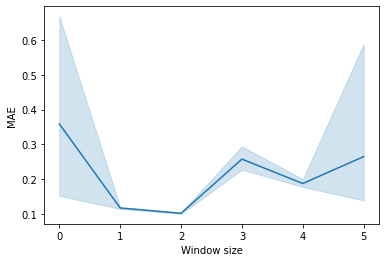

In [54]:
sns.lineplot(x='level_0', y='mae', data=results_total)
plt.ylabel('MAE')
plt.xlabel('Window size')

In [ ]:

sns.lineplot(x='mse', y='', data = results)
plt.show()

In [175]:
np.mean(results_window[4].loc[results_window[4].metrics < 10000].metrics)

0.33586437189025775